# Predicting Air Quality in Lagos: A Time Series Model for PM2.5 Levels

This model leveraging data sourced from Open Africa, presents a sophisticated time series analysis focused on predicting `PM2.5` air quality levels in `Lagos`, `Nigeria`.
`Lagos`, recognized as one of the most populous cities in Africa, faces significant environmental challenges, particularly in air quality. 

The model utilizes historical air quality data to forecast `PM2.5` concentrations, which are crucial for assessing environmental health risks. The predictions generated by this model are invaluable for urban planners, environmental policymakers, and public health officials in `Lagos`.

It offers insights into temporal pollution trends and empowers proactive measures for pollution control. By accurately forecasting `PM2.5` levels, this tool is instrumental in shaping strategies for improving air quality and enhancing the overall health and well-being of Lagos's residents."

In [1]:
# Importing the necessary libraries

import time
import pytz
import warnings

import pandas as pd
from pprint import PrettyPrinter

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Data Preparation

In [2]:
# Instantiating MongoClient and creating empty database

client = MongoClient(host="localhost", port=27017)
db = client["lagos"]

In [3]:
def wrangle(csv, resample_data="1H"):
    
    # Reading the csv data into a DataFrame, specifying the delimiter
    df = pd.read_csv(csv, delimiter=";")

    # Changing the data to a "list of dict" preparing it to be added to a MongoDB database
    data = df.to_dict(orient="records")

    # Deleting the `"Sensor_id"` column due to it's duplicate value since it will be the unique`"_id"` column (primary key)
    for doc in data:
        doc.pop("sensor_id", None)

    # Instantiating MongoClient and creating an empty database
    client = MongoClient(host="localhost", port=27017)
    db = client["lagos"]

    # Adding the document to the MongoDB collection
    collection = db["air-quality"]
    collection.insert_many(data)

    # Selecting only the `"P2"' readings and the corresponding '"timestamp"' from the data
    result = collection.find(
    {"value_type": "P2"},
    {"value": 1, "timestamp": 1, "_id": 0}
    )

    result = list(result)

    # Reading the selected reading into a dataframe, setting the `"timeframe"` as index
    df = pd.DataFrame(result).set_index("timestamp")
    df.rename(columns={"value": "P2"}, inplace=True)

    # setting the data type of the index as datetime
    df.index = pd.to_datetime(df.index)

    # Remove Outliers
    # df = df[df < 140]

    # Resample the data and forward-fill missing data
    df =df.resample(resample_data).mean().fillna(method="ffill")

    # Convert timezone to "Africa/Lagos"
    df.index = df.index.tz_convert("Africa/Lagos")

    return df["P2"]
      

In [48]:
y = wrangle("dataset.csv")
y.head()

timestamp
2023-11-01 17:00:00+01:00    19.00
2023-11-01 18:00:00+01:00     3.25
2023-11-01 19:00:00+01:00    40.33
2023-11-01 20:00:00+01:00    40.33
2023-11-01 21:00:00+01:00    40.33
Freq: H, Name: P2, dtype: float64

In [49]:
y.describe()

count    1185.000000
mean       29.700289
std        26.053789
min         3.250000
25%         4.650000
50%        34.270000
75%        40.330000
max       145.339000
Name: P2, dtype: float64

## Exploring the data

### Plotting a Box Plot 

###### This plots the distribution of the Series based on a five-number summary:
- Minimum
- First quartile (Q1)
- Median
- Third quartile (Q3)
- Maximum

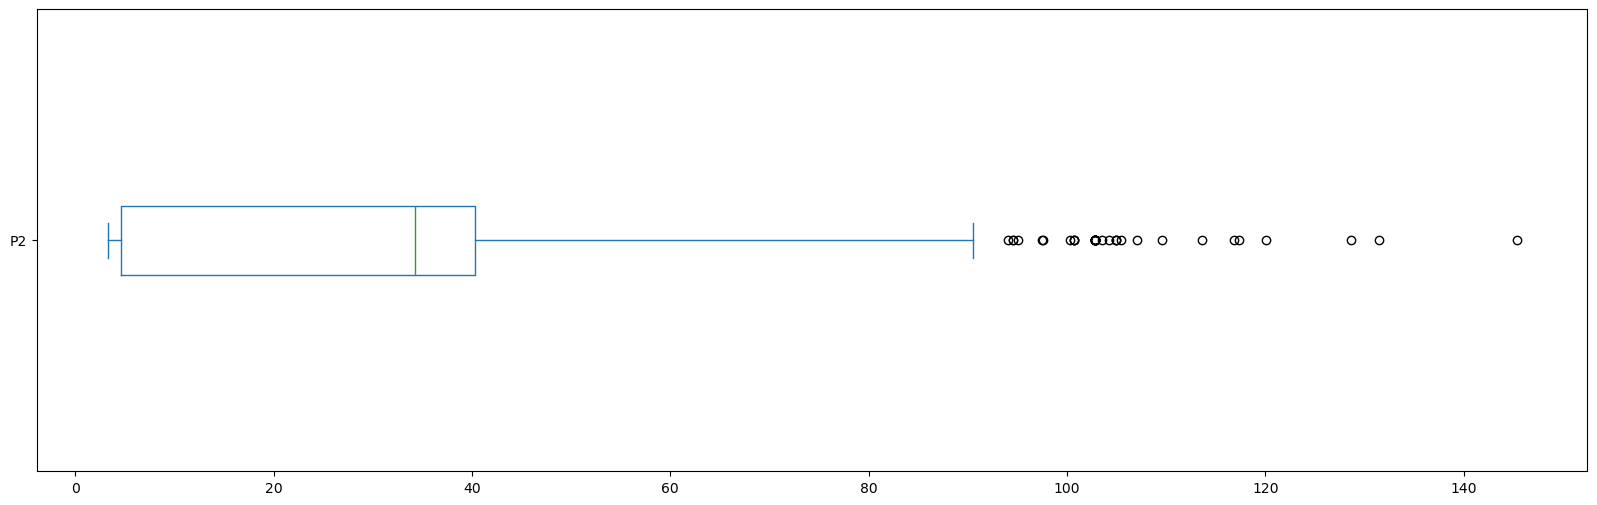

In [50]:
fig, ax = plt.subplots(figsize=(20, 6))
y.plot(kind="box", vert=False, ax=ax);

### ACF Plot

###### This plot assists in identifying the order of the Moving Average (MA) part of the ARIMA model.

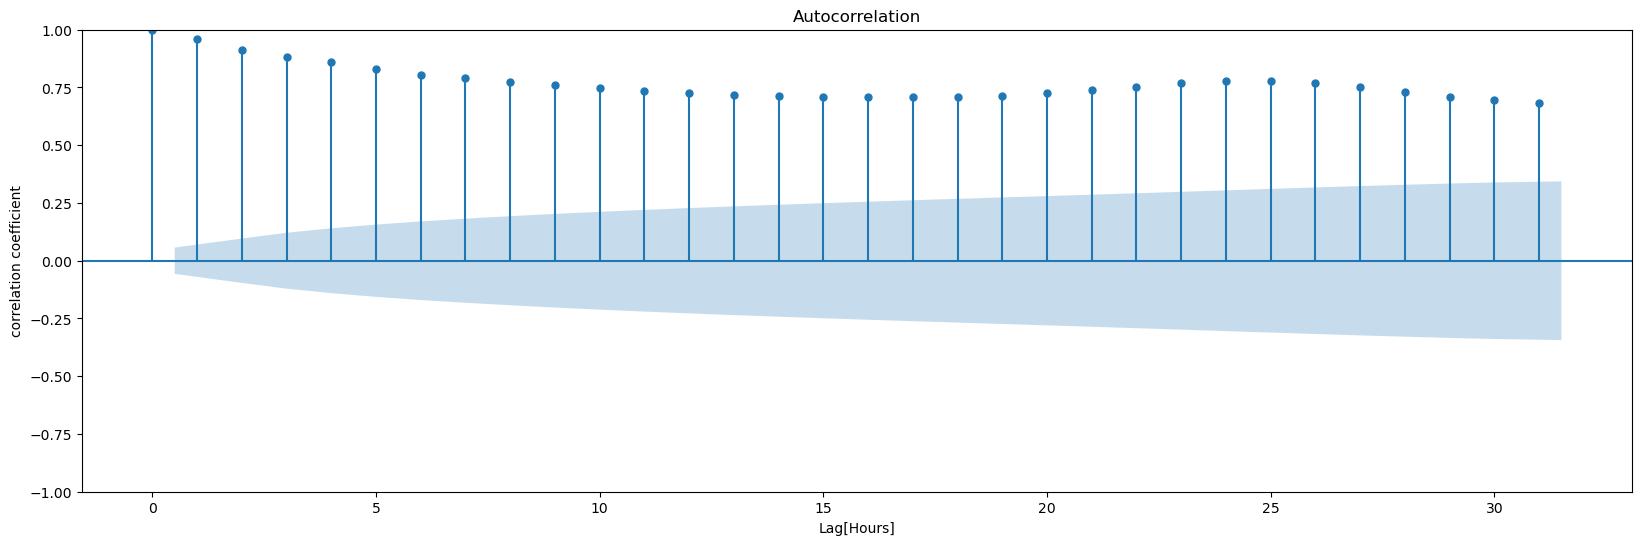

In [51]:
# Create a Canvas for the `ACF` plot
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the AutoCorrelation Function (ACF) for the Time series on the specified axis `ax`
plot_acf(y, ax=ax)
plt.xlabel("Lag[Hours]")
plt.ylabel("correlation coefficient");

### PACF Plot

###### This plot assists in identifying the order of the AutoRegression (AR) part of the ARIMA model.

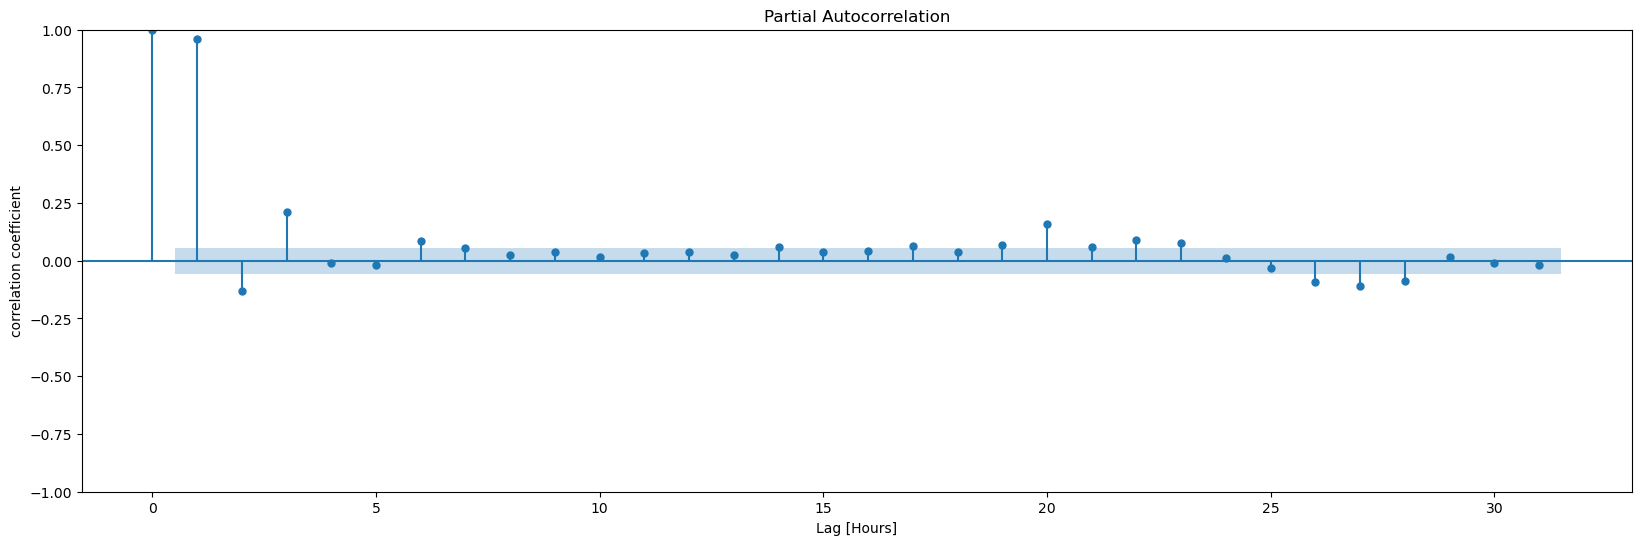

In [52]:
# Create a Canvas for the `ACF` plot
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the Partial AutoCorrelation Function (PACF) for the Time series on the specified axis `ax`
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("correlation coefficient");

### Time Series Plot

###### This is a plot of the Time series data using Python's matplotlib and pandas libraries.

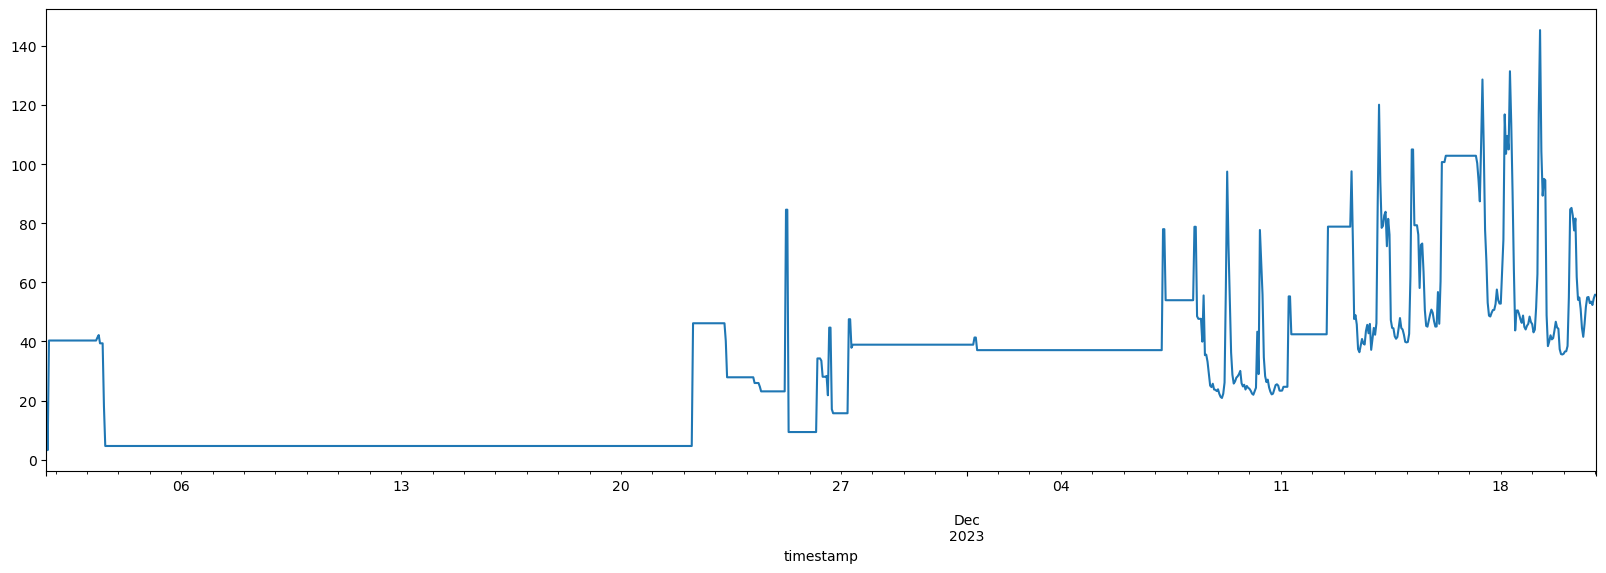

In [53]:
fig, ax = plt.subplots(figsize=(20, 6))
y.plot(ax=ax);

In [54]:
y.describe()

count    1185.000000
mean       29.700289
std        26.053789
min         3.250000
25%         4.650000
50%        34.270000
75%        40.330000
max       145.339000
Name: P2, dtype: float64

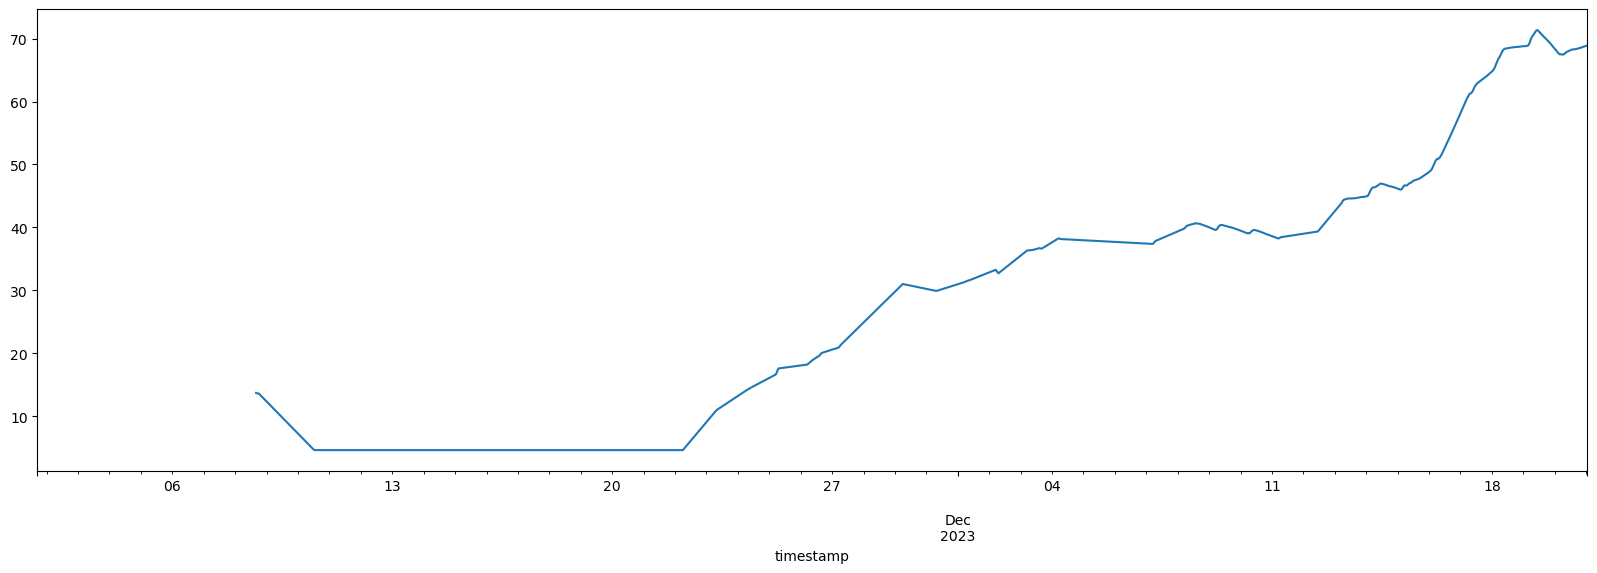

In [55]:
fig, ax = plt.subplots(figsize=(20, 6))
rolling_mean = y.rolling(168).mean()
rolling_mean.plot();

In [56]:
y.shape

(1185,)

## Augmented Dickey-Fuller test

###### The Augmented Dickey-Fuller (ADF) test, is a statistical test used to test for the presence of a unit root in a time series sample. It is primarily used to help determine whether a time series is stationary or not. 

###### The null hypothesis `Ho` in an ADF test is that the data is `stationary`.
###### If the `p-value` is less than the significant value (0.05) then we can reject the null hypothesis.
###### If the `ADF statistics` is less than any of the `critical values`, we can reject the null hypothesis.

In [57]:
# Run the `Augmented Dickey-fuller test` to check if the dataset is stationary.
adf_test = adfuller(y, autolag="AIC")

In [58]:
# Extract and display the results of the test
adf_statistic = adf_test[0]  # Test statistic
p_value = adf_test[1]  # p-value
critical_values = adf_test[4]  # Critical values for the test statistic at the 1 %, 5 %, and 10 % levels
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpretation
if p_value < 0.05:
    print("Reject null hypothesis: The series is stationary.")
else:
    print("Accept null hypothesis: The series is non-stationary.")

ADF Statistic: -1.1678981314353338
p-value: 0.6872504907448165
Critical Values:
   1%: -3.4359901072390353
   5%: -2.86403051064684
   10%: -2.5680960046332366
Accept null hypothesis: The series is non-stationary.


## Test-Train Split

###### Splitting the Series into training and testing data

###### Splitting time series data is done sequentially rather than randomly. We create a vertical `cut-off`, everything to the left stays as the `training series` while those at the right become `test series`.

In [61]:
cutoff = int(len(y) * 0.9)
y_train = y[cutoff:]
y_test = y[:cutoff]

## Differencing the dataset to achieve a stationary series

`Differencing` is a common method to make a `non-stationary` time series `stationary`. It helps in removing trends and seasonality from the data.

In [62]:
diff_data = y_train.diff().dropna()

## Repeating the ADF test to see if the Series is `stationary`

In [63]:
adf_diff = adfuller(diff_data,  autolag="AIC")
stationary_value = 0.05

p_value = adf_diff[1]
print(f"ADF stats: {adf_diff[0]}")
print(f"p_value: {p_value}")

print("critical values")
for key, value in adf_diff[4].items():
    print(f"{key}: {value}")

if p_value < stationary_value:
    print("Reject null hypothesis: Series is stationary")
else:
    print("Accept null hypothesis: Series is non-stationary")

ADF stats: -5.3692118273922915
p_value: 3.929808337227317e-06
critical values
1%: -3.489589552580676
5%: -2.887477210140433
10%: -2.580604145195395
Reject null hypothesis: Series is stationary


## Sampling the ACF, PACF, Rolling Mean and Time Series Plots for the Stationary Series

#### ACF Plot

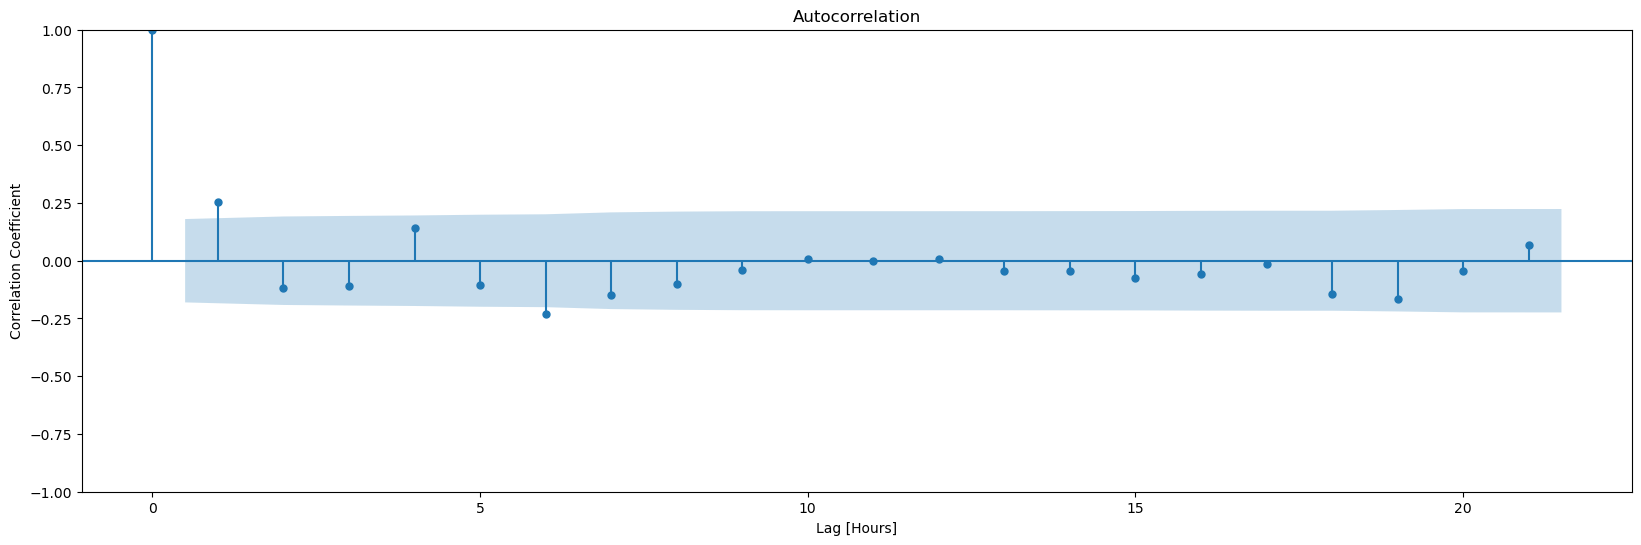

In [64]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_acf(diff_data, ax=ax)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Lag [Hours]");

#### PACF Plot

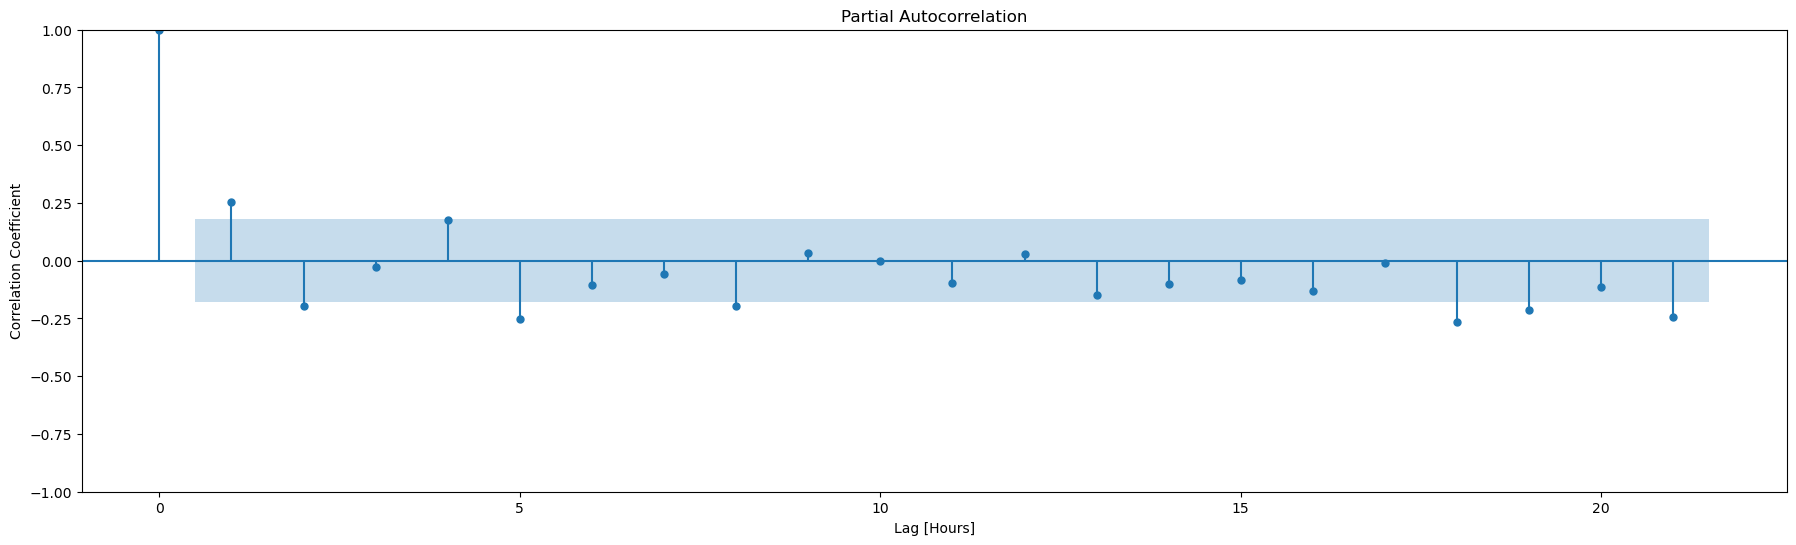

In [106]:
fig, ax = plt.subplots(figsize=(22, 6))
plot_pacf(diff_data, ax=ax)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Lag [Hours]");

#### Time Series Plot

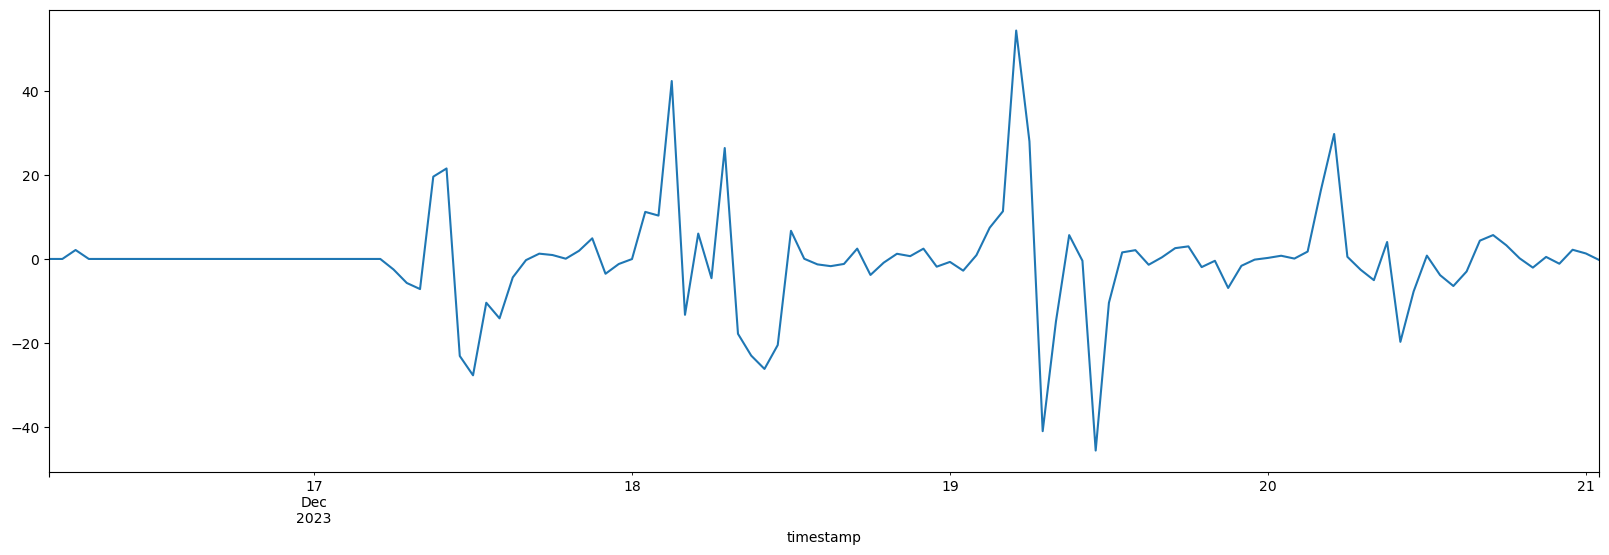

In [66]:
fig, ax = plt.subplots(figsize=(20, 6))
diff_data.plot(ax=ax);

#### Rolling mean Plot

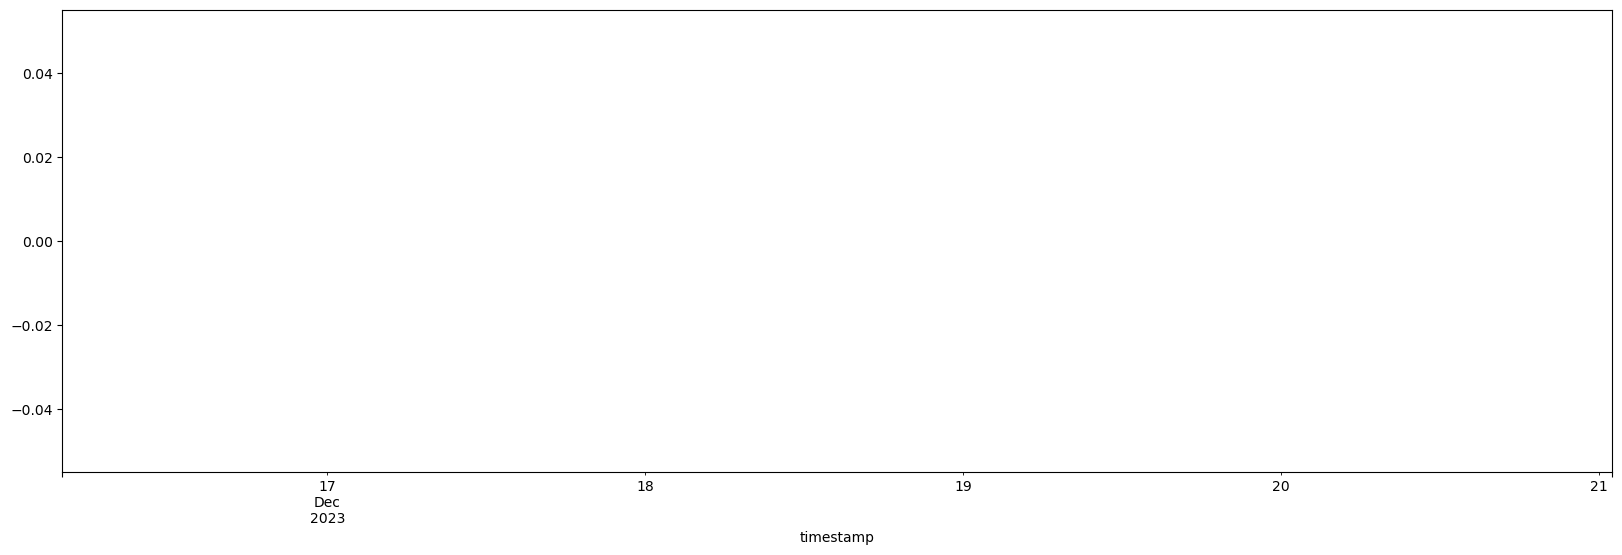

In [68]:
fig, ax = plt.subplots(figsize=(20, 6))
rolling_mean = diff_data.rolling(168).mean()
rolling_mean.plot();

### Baseline Model

###### Building the baseline model with the stationary dataset

In [69]:
# Building a baseline model 
y_train_mean = diff_data.mean() 
y_baseline = [y_train_mean] * len(diff_data)

# Calculating the performance metric of the baseline model
mae_baseline = mean_absolute_error(diff_data, y_baseline)
print(f'Mean P2 reading: {round(y_train_mean, 3)}')
print(f'Baseline MAE: {round(mae_baseline, 3)}')

Mean P2 reading: -0.382
Baseline MAE: 6.441


### Instantiate and train the model

In [130]:
# Getting the orders for the AR and MA from the pacf and acf plots respectively
# Since the data is non-stationary, i decided to try first-order differencing

p_params = range(2, 6, 2) 
q_params = [1,2,3]

# A dict for the Mean absolute errors and information criteria of each model 
mae_grid = dict()
aic_dict = dict()

for p in p_params:
    mae_grid[p] = list()
    aic_dict[p] = list()
    for q in q_params:
        order = (p, 0, q)

        # Calculating how long it takes to build and Train the model for each iterations of the AR and MA orders
        start_time = time.time()

        # building and fiting the models with the different iterations
        model = ARIMA(y_train, order=(p,0,q)).fit()

        end_time = time.time()
        time_diff = round((end_time - start_time), 2)
        #print(f"Trained ARIMA{order} in {time_diff}sec")

        # Get the Akike information criteria (AIC) of each model
        aic = model.aic        
        aic_dict[p].append(round(aic,2))

        
        # calculate the performance metric of the models
        y_pred = model.predict()
        mae = mean_absolute_error(y_pred, y_train)
        # Adding the MAE to the list 
        mae_grid[p].append(round(mae, 2))

print(f"AIC: {aic_dict}")       
print(f"MAE: {mae_grid}") 

AIC: {2: [925.41, 921.09, 918.72], 4: [927.04, 916.9, 918.55]}
MAE: {2: [7.05, 7.2, 7.12], 4: [6.96, 7.1, 7.15]}


In [131]:
mae_df = pd.DataFrame(mae_grid)
mae_df

,2,4
0,7.05,6.96
1,7.20,7.10
2,7.12,7.15


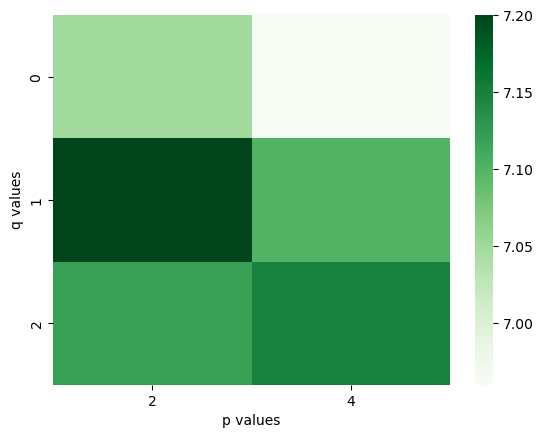

In [132]:
sns.heatmap(mae_df, cmap="Greens")
plt.xlabel("p values")
plt.ylabel("q values");

## Walk Forward Validation of the Model

 In the bid to determine the combination of MA and AR orders that gives the best form of performance, I'll create a function that does the Walk-Forward Validation for each of the combinations from the above iteration.

In [133]:
def w_fwd_val(p, q):
    """ Takes in 2 inputs for the orders of the AR and MA model, 
    performs walk forward validation on model and returns the walk forward series
    """
    next_preds = []

    # Convert the initial history to a list
    history_list = diff_data.tolist()  
    
    for i in range(len(y_test)):
        model = ARIMA(history_list, order=(p, 0, q)).fit()
    
        # Forecasting the next reading
        next_pred_value = model.forecast()[0]
        
        # Updating the walk forward validation series with the latest forecast
        next_preds.append(next_pred_value)
    
        # Updating the training data with the most recent data
        history_list.append(y_test.iloc[i])

    
    y_pred_wfv = pd.Series(next_preds, index=y_test.index)    
    y_pred_wfv.name = "prediction"
    y_pred_wfv.index.name = "timestamp"

    return y_pred_wfv

### Calculating the Performance of the Walk forward Validation of each combination of order for the ARIMA Model

In [134]:
# Looping through the values of p
orders = dict()
for p in p_params:
    print(p)
    # Looping through all the values of q for each value for p
    for q in q_params:
        # Calculating the Mean Absolute Error 
        mae_wfv = mean_absolute_error(y_test, w_fwd_val(p, q))
        orders[(p,q)] = round(mae_wfv, 3)
        print(f'MAE after wfv of ARIMA({p},{q}): {round(mae_wfv, 3)}')

2
MAE after wfv of ARIMA(2,1): 27.726
MAE after wfv of ARIMA(2,2): 2.449
MAE after wfv of ARIMA(2,3): 2.443
4
MAE after wfv of ARIMA(4,1): 2.513
MAE after wfv of ARIMA(4,2): 2.587
MAE after wfv of ARIMA(4,3): 2.508


#### Getting the order combination that gives smallest Mean Absolute Error from all the combinations

In [135]:
best_order = min(orders, key=orders.get)
best_order

(2, 3)

## Evaluate

Doing the walf forward validation for the entire training set with the best version of our model.

In [136]:
# Initialize the list to hold predictions and history
next_preds = []
history_list = diff_data.tolist()  # Convert the initial history to a list

# Assign the best orders for the AR and MA models respectively
p, q = best_order

# Iterate over the test set
for t in range(len(y_test)):
    # Fit the ARIMA model
    model = ARIMA(history_list, order=(p, 0, q)).fit()
    
    # Forecast the next step
    next_pred_value = model.forecast()[0]
    
    # Store the forecasted value
    next_preds.append(next_pred_value)
    
    # Update the history with the true value for the next loop iteration
    history_list.append(y_test.iloc[t])

# Convert the list of predictions to a pandas Series
diff_wfv = pd.Series(next_preds, index=y_test.index)
diff_wfv.name = "prediction"
diff_wfv.index.name = "timestamp"
diff_wfv.head()

timestamp
2023-11-01 17:00:00+01:00    -3.767549
2023-11-01 18:00:00+01:00     3.826228
2023-11-01 19:00:00+01:00    -5.669685
2023-11-01 20:00:00+01:00     1.846790
2023-11-01 21:00:00+01:00    10.364014
Freq: H, Name: prediction, dtype: float64

### Model Performance on Test data

#### Calculating the Mean Absolute Error of the Model on `y_test` data

In [137]:
test_mae = mean_absolute_error(y_test, diff_wfv)
print(f'Test Model Mean Absolute Error: {round(test_mae, 2)}')

Test Model Mean Absolute Error: 2.44


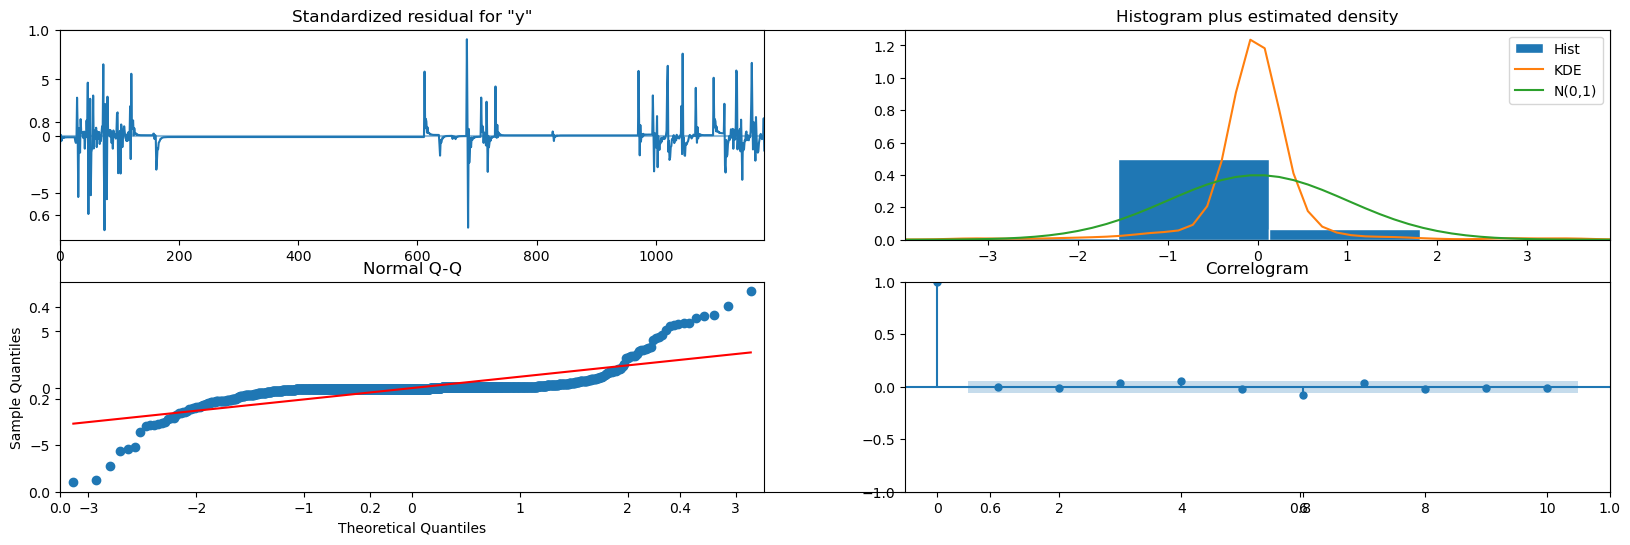

In [138]:
fig, ax = plt.subplots(figsize=(20, 6))
model.plot_diagnostics(fig=fig);

### Communicating Result

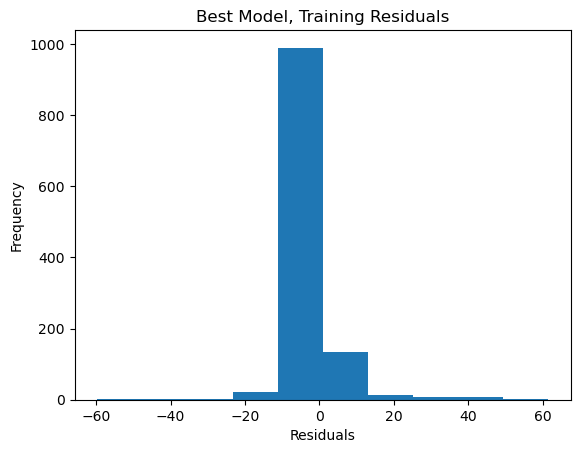

In [139]:
residual = model.resid
plt.hist(residual)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals");

In [152]:
df_predictions = pd.DataFrame({
    "y_test": y_test,
    "y_pred": diff_wfv
}, index=y_test.index)


In [158]:
# Negative Predictions
negative_pred = df_predictions[df_predictions["y_pred"] < 0]
negative_pred

,y_test,y_pred
timestamp,,
2023-11-01 17:00:00+01:00,19.00,-3.767549
2023-11-01 19:00:00+01:00,40.33,-5.669685
2023-11-01 22:00:00+01:00,40.33,-6.102443


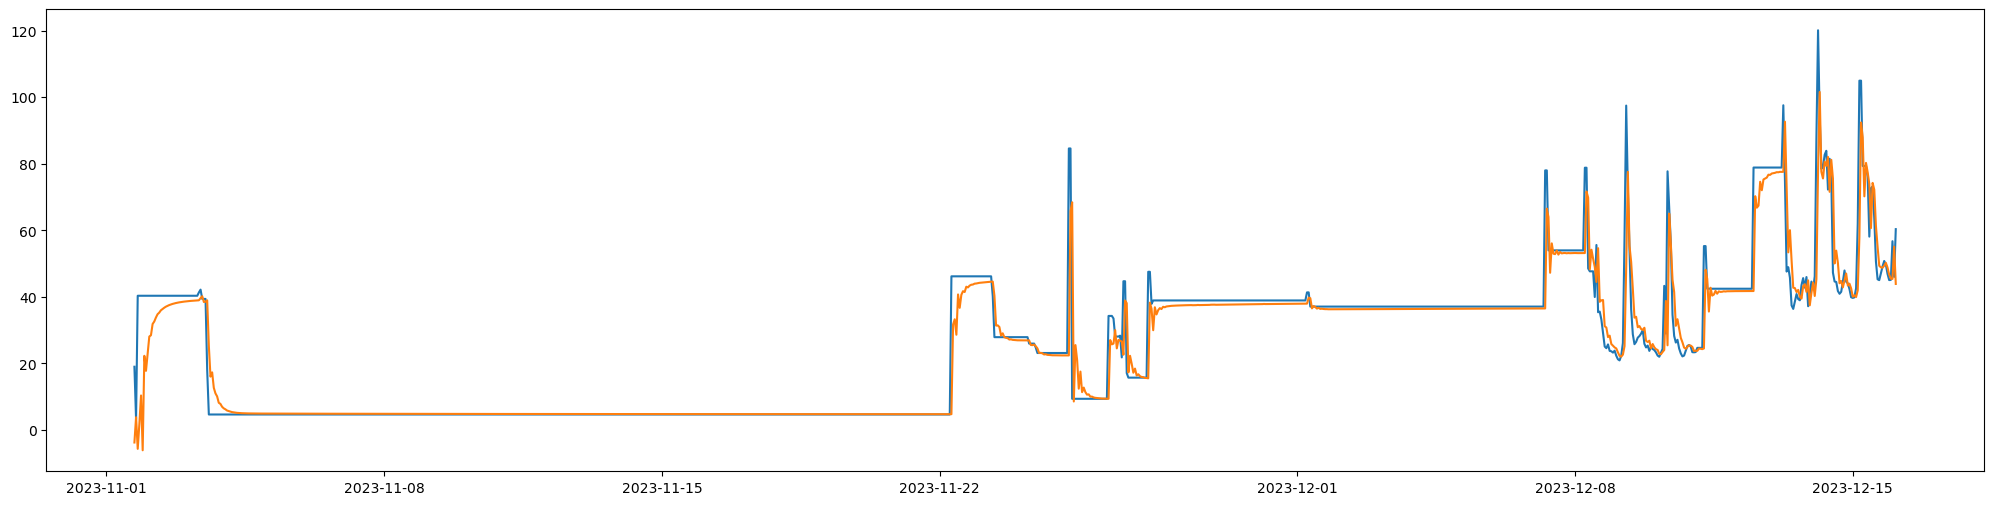

In [147]:
fig, ax = plt.subplots(figsize=(25, 6))
plt.plot(df_predictions);